In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# from imblearn.under_sampling import RandomUnderSampler
from prettytable import PrettyTable
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, auc

In [2]:
df = pd.read_csv('combined_csv.csv')
df.head()

,Unnamed: 0,OccupancyDateTime,PaidOccupancy,SideOfStreet,SourceElementKey,ParkingTimeLimitCategory,ParkingSpaceCount,PaidParkingRate,ParkingCategory,Latitude,...,class,type,date_category,rate_category,time_limit_category,weather_category,humidity_category,precip_category,snow_category,holiday_category
0,0,2015-01-15 12:15:00,1,NE,10202,240,22,4.0,Paid Parking,47.608585,...,highway,construction,Weekday,High,Medium,Cold,Medium,No Rain,No Snow,False
1,1,2015-01-16 17:01:00,1,NW,94421,240,7,4.0,Paid Parking,47.608350,...,man_made,bioswale,Weekday,High,Medium,Cold,Medium,No Rain,No Snow,False
2,2,2015-01-15 11:19:00,1,NW,94421,240,7,4.0,Paid Parking,47.608350,...,man_made,bioswale,Weekday,High,Medium,Cold,Medium,No Rain,No Snow,False
3,3,2015-01-15 11:51:00,9,NW,80177,240,8,4.0,Paid Parking,47.608180,...,place,house,Weekday,High,Medium,Cold,Medium,No Rain,No Snow,False
4,4,2015-01-16 16:51:00,3,NW,80177,240,8,4.0,Paid Parking,47.608180,...,place,house,Weekday,High,Medium,Cold,Medium,No Rain,No Snow,False


In [3]:
df = df.drop(['date_category', 'rate_category' , 'time_limit_category', 'weather_category', 'humidity_category', 'precip_category', 'snow_category', 'holiday_category', 'is_weekend'], axis=1)

count_missing_data=df.isnull().sum()
print(count_missing_data)

# Check for duplicates
duplicates = df[df.duplicated()]

# Print the duplicates
print("Duplicate Rows except first occurrence:")
print(duplicates)

# Optionally, you can also print the count of duplicates
print("\nNumber of duplicate rows (excluding the first occurrence):", duplicates.shape[0])

Unnamed: 0                        0
OccupancyDateTime                 0
PaidOccupancy                     0
SideOfStreet                      0
SourceElementKey                  0
ParkingTimeLimitCategory          0
ParkingSpaceCount                 0
PaidParkingRate             1923555
ParkingCategory                   0
Latitude                          0
Longitude                         0
is_us_holiday                     0
temp                              0
feelslike                         0
humidity                          0
precip                            0
snow                              0
class                             0
type                              0
dtype: int64
Duplicate Rows except first occurrence:
Empty DataFrame
Columns: [Unnamed: 0, OccupancyDateTime, PaidOccupancy, SideOfStreet, SourceElementKey, ParkingTimeLimitCategory, ParkingSpaceCount, PaidParkingRate, ParkingCategory, Latitude, Longitude, is_us_holiday, temp, feelslike, humidity, precip, snow, cla

In [4]:
# Remove duplicates from the original DataFrame
df = df.drop_duplicates()


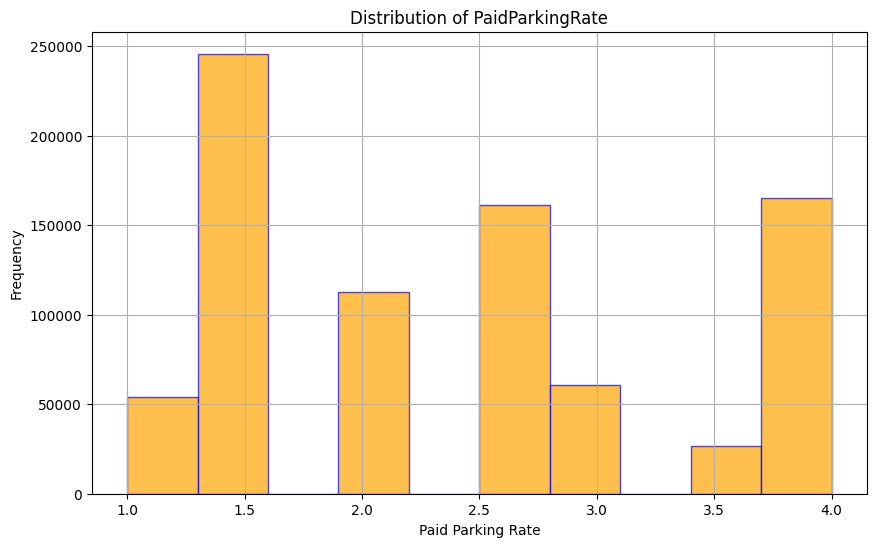

In [5]:
# Plot the distribution of Paid Parking Rate
plt.figure(figsize=(10, 6))
# plt.hist(df['Paid Parking Rate'], bins=10, color='skyblue', edgecolor='black')
plt.hist(df['PaidParkingRate'], bins=10, facecolor='orange', edgecolor='blue', alpha=0.7)
plt.title('Distribution of PaidParkingRate')
plt.xlabel('Paid Parking Rate')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [6]:
# Define bin edges and labels
bin_edges = [0, 2, 3, 5]  # Adjust the bin edges as needed
bin_labels = ['Low Surge', 'Moderate Surge', 'High Surge']

# Create a new column 'SurgeLevel' based on the bins
df['SurgeLevel'] = pd.cut(df['PaidParkingRate'], bins=bin_edges, labels=bin_labels, include_lowest=True)

# Display the result
df.head()


,Unnamed: 0,OccupancyDateTime,PaidOccupancy,SideOfStreet,SourceElementKey,ParkingTimeLimitCategory,ParkingSpaceCount,PaidParkingRate,ParkingCategory,Latitude,Longitude,is_us_holiday,temp,feelslike,humidity,precip,snow,class,type,SurgeLevel
0,0,2015-01-15 12:15:00,1,NE,10202,240,22,4.0,Paid Parking,47.608585,-122.34281,False,44.1,44.1,65.93,0.0,0.0,highway,construction,High Surge
1,1,2015-01-16 17:01:00,1,NW,94421,240,7,4.0,Paid Parking,47.608350,-122.34234,False,50.0,49.2,64.31,0.0,0.0,man_made,bioswale,High Surge
2,2,2015-01-15 11:19:00,1,NW,94421,240,7,4.0,Paid Parking,47.608350,-122.34234,False,42.7,38.2,67.42,0.0,0.0,man_made,bioswale,High Surge
3,3,2015-01-15 11:51:00,9,NW,80177,240,8,4.0,Paid Parking,47.608180,-122.34218,False,44.1,44.1,65.93,0.0,0.0,place,house,High Surge
4,4,2015-01-16 16:51:00,3,NW,80177,240,8,4.0,Paid Parking,47.608180,-122.34218,False,50.0,49.2,64.31,0.0,0.0,place,house,High Surge


In [7]:
df['OccupancyDateTime'] = pd.to_datetime(df['OccupancyDateTime'])
# Load the dataset and create categorical PaidParkingRate
bins = [i * 0.5 for i in range(9)]
labels = [i for i in range(1, len(bins))]
# data['CategoricalPaidParkingRate'] = pd.cut(data['PaidParkingRate'], bins=bins, labels=labels, include_lowest=True)

# df['Year'] = df['OccupancyDateTime'].dt.year
df['Hour'] = df['OccupancyDateTime'].dt.hour
df['Day'] = df['OccupancyDateTime'].dt.day
df['Weekday'] = df['OccupancyDateTime'].dt.weekday
df['Month'] = df['OccupancyDateTime'].dt.month
# data['OccupancyDateTime'] = pd.to_datetime(data['OccupancyDateTime']).astype(np.int64)
df.head(10)


# Calculate the distance from 
from geopy.distance import great_circle
# Convert 'OccupancyDateTime' to datetime
df['OccupancyDateTime'] = pd.to_datetime(df['OccupancyDateTime'])

# Filter the df for the specified week
week_df = df[(df['OccupancyDateTime'] >= '2015-01-12') & (df['OccupancyDateTime'] <= '2015-01-18')]

# Filter out entries with the maximum 'PaidParkingRate'
downtown_df = week_df[week_df['PaidParkingRate'] == 4]

# Calculate the centroid of downtown
downtown_centroid = (downtown_df['Latitude'].mean(), downtown_df['Longitude'].mean())

# Function to calculate distance from downtown for each row
def calculate_distance_from_downtown(lat, lon, downtown_centroid):
    return great_circle((lat, lon), downtown_centroid).kilometers

# Apply the function to each row
df['DistanceFromDowntown'] = df.apply(
    lambda row: calculate_distance_from_downtown(row['Latitude'], row['Longitude'], downtown_centroid), axis=1
)

# Save the updated dfframe to a new CSV file
df.to_csv('path_to_updated_df.csv', index=False)

# Print out the first few rows to check the new column
df[['SourceElementKey', 'Latitude', 'Longitude', 'PaidParkingRate', 'DistanceFromDowntown']].head(50)

df=df.drop('OccupancyDateTime',axis=1)
df.head()

,Unnamed: 0,PaidOccupancy,SideOfStreet,SourceElementKey,ParkingTimeLimitCategory,ParkingSpaceCount,PaidParkingRate,ParkingCategory,Latitude,Longitude,...,precip,snow,class,type,SurgeLevel,Hour,Day,Weekday,Month,DistanceFromDowntown
0,0,1,NE,10202,240,22,4.0,Paid Parking,47.608585,-122.34281,...,0.0,0.0,highway,construction,High Surge,12,15,3,1,0.913891
1,1,1,NW,94421,240,7,4.0,Paid Parking,47.608350,-122.34234,...,0.0,0.0,man_made,bioswale,High Surge,17,16,4,1,0.877373
2,2,1,NW,94421,240,7,4.0,Paid Parking,47.608350,-122.34234,...,0.0,0.0,man_made,bioswale,High Surge,11,15,3,1,0.877373
3,3,9,NW,80177,240,8,4.0,Paid Parking,47.608180,-122.34218,...,0.0,0.0,place,house,High Surge,11,15,3,1,0.864880
4,4,3,NW,80177,240,8,4.0,Paid Parking,47.608180,-122.34218,...,0.0,0.0,place,house,High Surge,16,16,4,1,0.864880


In [8]:
from more_itertools import tabulate


def classify_area(class_name):
    if class_name in ['building','leisure', 'craft']:
        return 'residential'
    elif class_name in ['amenity', 'place','tourism','shop' , 'office', 'historic', 'healthcare', 'railway']:
        return 'commercial'
    elif class_name in ['building', 'highway', 'man_made', ]:
        return 'mixed-use'
    else:
        return 'other'

# Apply the function to the 'class' column to create the new 'area_type' column
df['area_type'] = df['class'].apply(classify_area)

# Compute value counts
value_counts = df['area_type'].value_counts()

# Convert to DataFrame for pretty printing
value_counts_df = pd.DataFrame(value_counts).reset_index()

# Rename columns for clarity
value_counts_df.columns = ['area_type', 'count']

# # Print in a pretty table
# print(tabulate(value_counts_df, headers='keys', tablefmt='psql'))

from tabulate import tabulate

# # Assuming your DataFrame is named 'value_counts_df'
# value_counts_df = df['area_type'].value_counts().reset_index()
# value_counts_df.columns = ['area_type', 'count']
  
# Print in a pretty table
print(tabulate(value_counts_df, tablefmt='psql'))

# Add 'rain' column
df['rain'] = df['precip'] > 0

# Drop rows where 'precip' is NaN
df_no_na = df.dropna()

# Access the 'precip' column from the DataFrame with no NaN values
precip_values = df_no_na['precip']
# Identify numerical features
numerical_features = df.select_dtypes(include=['int', 'float']).columns

# Identify categorical features
categorical_features = df.select_dtypes(include=['object', 'category','bool']).columns

# Print the results
print("Numerical Features:")
print(numerical_features)

print("\nCategorical Features:")
print(categorical_features)

# columns_to_drop=['snow','Unnamed: 0']
# df=df.drop(columns_to_drop)
geo_df =df

geo_df.to_csv('geo_df.csv',index=False)
geo_df.head()

+---+-------------+---------+
| 0 | commercial  | 1492384 |
| 1 | residential | 1043068 |
| 2 | mixed-use   |  214659 |
+---+-------------+---------+
Numerical Features:
Index(['Unnamed: 0', 'PaidOccupancy', 'SourceElementKey',
       'ParkingTimeLimitCategory', 'ParkingSpaceCount', 'PaidParkingRate',
       'Latitude', 'Longitude', 'temp', 'feelslike', 'humidity', 'precip',
       'snow', 'Hour', 'Day', 'Weekday', 'Month', 'DistanceFromDowntown'],
      dtype='object')

Categorical Features:
Index(['SideOfStreet', 'ParkingCategory', 'is_us_holiday', 'class', 'type',
       'SurgeLevel', 'area_type', 'rain'],
      dtype='object')


,Unnamed: 0,PaidOccupancy,SideOfStreet,SourceElementKey,ParkingTimeLimitCategory,ParkingSpaceCount,PaidParkingRate,ParkingCategory,Latitude,Longitude,...,class,type,SurgeLevel,Hour,Day,Weekday,Month,DistanceFromDowntown,area_type,rain
0,0,1,NE,10202,240,22,4.0,Paid Parking,47.608585,-122.34281,...,highway,construction,High Surge,12,15,3,1,0.913891,mixed-use,False
1,1,1,NW,94421,240,7,4.0,Paid Parking,47.608350,-122.34234,...,man_made,bioswale,High Surge,17,16,4,1,0.877373,mixed-use,False
2,2,1,NW,94421,240,7,4.0,Paid Parking,47.608350,-122.34234,...,man_made,bioswale,High Surge,11,15,3,1,0.877373,mixed-use,False
3,3,9,NW,80177,240,8,4.0,Paid Parking,47.608180,-122.34218,...,place,house,High Surge,11,15,3,1,0.864880,commercial,False
4,4,3,NW,80177,240,8,4.0,Paid Parking,47.608180,-122.34218,...,place,house,High Surge,16,16,4,1,0.864880,commercial,False


/var/folders/g8/gc9zn7d515q2qc1hg5fc4kf00000gn/T/ipykernel_59893/3521000843.py:13: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  data_filtered = data = pd.read_csv('geo_df.csv')


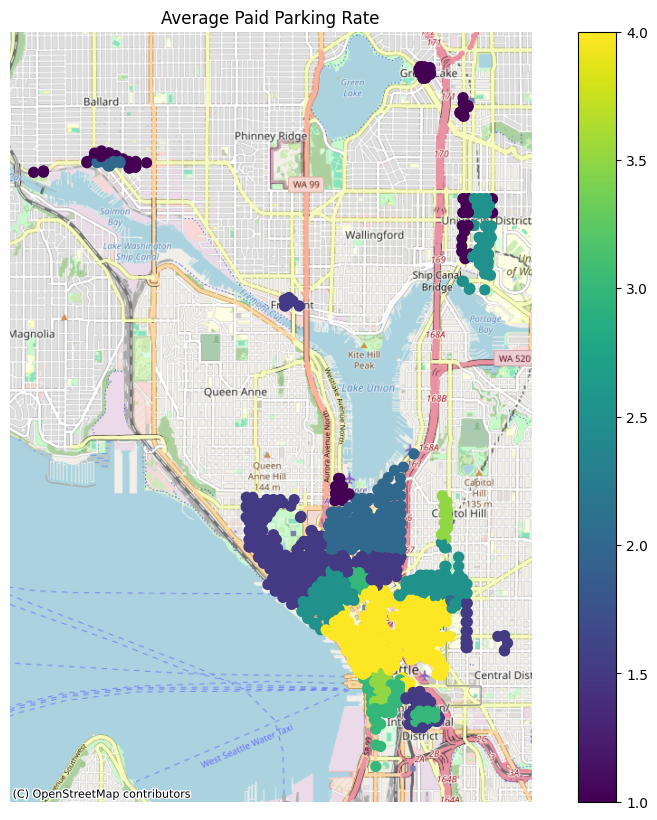

,Unnamed: 0,PaidOccupancy,SideOfStreet,SourceElementKey,ParkingTimeLimitCategory,ParkingSpaceCount,PaidParkingRate,ParkingCategory,Latitude,Longitude,is_us_holiday,temp,feelslike,humidity,precip,snow,class,type,SurgeLevel,Hour,Day,Weekday,Month,DistanceFromDowntown,area_type,rain
0,0,1,NE,10202,240,22,4.0,Paid Parking,47.608585,-122.34281,False,44.1,44.1,65.93,0.0,0.0,highway,construction,High Surge,12,15,3,1,0.913891,mixed-use,False
1,1,1,NW,94421,240,7,4.0,Paid Parking,47.608350,-122.34234,False,50.0,49.2,64.31,0.0,0.0,man_made,bioswale,High Surge,17,16,4,1,0.877373,mixed-use,False
2,2,1,NW,94421,240,7,4.0,Paid Parking,47.608350,-122.34234,False,42.7,38.2,67.42,0.0,0.0,man_made,bioswale,High Surge,11,15,3,1,0.877373,mixed-use,False
3,3,9,NW,80177,240,8,4.0,Paid Parking,47.608180,-122.34218,False,44.1,44.1,65.93,0.0,0.0,place,house,High Surge,11,15,3,1,0.864880,commercial,False
4,4,3,NW,80177,240,8,4.0,Paid Parking,47.608180,-122.34218,False,50.0,49.2,64.31,0.0,0.0,place,house,High Surge,16,16,4,1,0.864880,commercial,False


In [9]:
##Nikhil's Code
import geopandas as gpd
import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt
# Convert 'OccupancyDateTime' to datetime
#reg_df['OccupancyDateTime'] = pd.to_datetime(reg_df['OccupancyDateTime'])

# Filter data for a specific date
#specific_date = '2015-01-15'
#data_filtered = reg_df[reg_df['OccupancyDateTime'].dt.date == pd.to_datetime(specific_date).date()]
pd.set_option('display.max_columns', 500)
data_filtered = data = pd.read_csv('geo_df.csv')
# Group by 'SourceElementKey' and calculate the mean 'PaidParkingRate'
parking_avg_rates = data_filtered.groupby('SourceElementKey').agg({
    'PaidParkingRate': 'mean',
    'ParkingSpaceCount': 'mean',
    'Latitude': 'first',
    'Longitude': 'first',
    'ParkingTimeLimitCategory': 'mean'

}).reset_index()

# Create a GeoDataFrame with the average rates and their corresponding coordinates
gdf = gpd.GeoDataFrame(parking_avg_rates, geometry=gpd.points_from_xy(parking_avg_rates.Longitude, parking_avg_rates.Latitude))

# Set the coordinate reference system (CRS) to WGS84 (epsg:4326) and then to Web Mercator (epsg:3857) for contextily
gdf = gdf.set_crs('epsg:4326')
gdf = gdf.to_crs(epsg=3857)

# Plotting the GeoDataFrame with a background map
fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(ax=ax, column='PaidParkingRate', cmap='viridis', legend=True, markersize=50)

# Add the background map
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set the aspect of the plot to be equal
ax.set_aspect('equal')

# Remove the axis for a cleaner look
ax.axis('off')

# Add title
plt.title(f'Average Paid Parking Rate')

# Display the plot
plt.show()
data.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


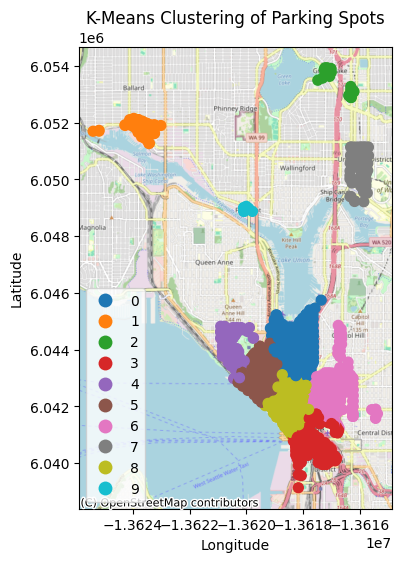

   SourceElementKey  PaidParkingRate  ParkingSpaceCount   Latitude  \
0              1001              3.5                5.0  47.602870   
1              1002              3.5                9.0  47.602947   
2              1005              4.0                5.0  47.603596   
3              1006              4.0                6.0  47.603676   
4              1009              4.0                5.0  47.605020   

    Longitude  ParkingTimeLimitCategory                           geometry  \
0 -122.334694                     120.0  POINT (-13618235.842 6041039.025)   
1 -122.334510                     120.0  POINT (-13618215.360 6041051.738)   
2 -122.335360                     120.0  POINT (-13618309.981 6041158.887)   
3 -122.335144                     120.0  POINT (-13618285.936 6041172.095)   
4 -122.336655                      30.0  POINT (-13618454.140 6041393.992)   

   kmeans_cluster  
0               3  
1               3  
2               8  
3               8  
4         

In [10]:
from sklearn.cluster import KMeans

# Assuming 'gdf' is the GeoDataFrame created earlier with 'Latitude' and 'Longitude'

# Use k-means to create a specified number of clusters, e.g., 10
kmeans = KMeans(n_clusters=10, random_state=42)
gdf['kmeans_cluster'] = kmeans.fit_predict(gdf[['Longitude', 'Latitude']])

# Visualize the k-means clusters
fig, ax = plt.subplots(figsize=(10, 6))

gdf.plot(ax=ax, column='kmeans_cluster', categorical=True, legend=True, markersize=50)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('K-Means Clustering of Parking Spots')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
print(gdf.head())
# Analyze clusters
cluster_avg_rates = gdf.groupby('kmeans_cluster')[['PaidParkingRate', 'ParkingSpaceCount', 'ParkingTimeLimitCategory', 'Longitude', 'Latitude']].mean().reset_index()
print(cluster_avg_rates)

In [11]:
cluster_avg_rates = gdf.groupby('kmeans_cluster').agg({
    'PaidParkingRate': 'mean',
    'ParkingSpaceCount': 'mean',
    'ParkingTimeLimitCategory': 'mean',
    'Longitude': 'mean',
    'Latitude': 'mean'
}).reset_index()

# Assume each parking space is occupied for its full time limit each time and calculate earnings per day
cluster_avg_rates['AvgMonthlyEarnings'] = cluster_avg_rates['ParkingSpaceCount'] * cluster_avg_rates['PaidParkingRate'] * (1440 / cluster_avg_rates['ParkingTimeLimitCategory'])

# Now calculate the total earnings per year for each cluster
annual_earnings = cluster_avg_rates.groupby('kmeans_cluster').agg({
    'AvgMonthlyEarnings': lambda x: x.sum() * 365,
    'Longitude': 'first',
    'Latitude': 'first'
})

# Display the total earnings per year for each cluster
annual_earnings.head(20)
annual_earnings.to_csv('annual_earnings.csv',index=False)

In [12]:
gdf.shape

(1489, 8)

/var/folders/g8/gc9zn7d515q2qc1hg5fc4kf00000gn/T/ipykernel_59893/1051600917.py:7: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('geo_df.csv')
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


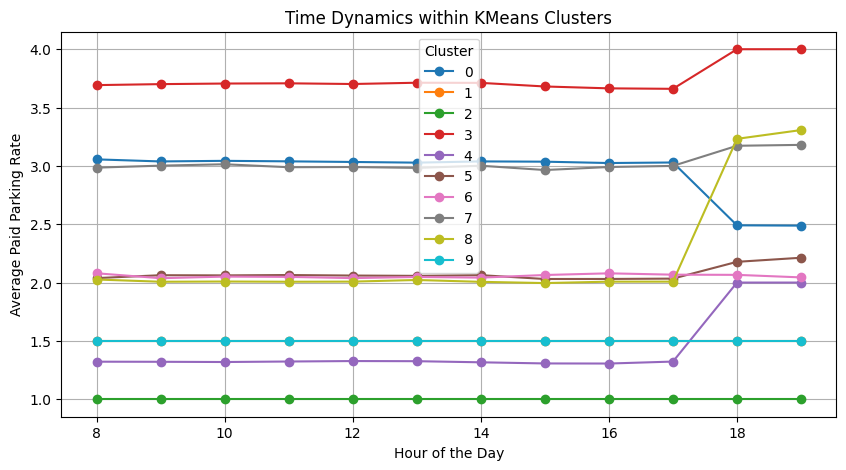

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load the data
data = pd.read_csv('geo_df.csv')

# Convert 'OccupancyDateTime' to datetime and extract the hour

# Standardize the geographic coordinates
scaler = StandardScaler()
coords = scaler.fit_transform(data[['Longitude', 'Latitude']])

# KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=42)
data['kmeans_cluster'] = kmeans.fit_predict(coords)

# Calculate mean PaidParkingRate for each cluster and hour
cluster_hourly_avg = data.groupby(['kmeans_cluster', 'Hour'])['PaidParkingRate'].mean().reset_index()

# Pivot the data to make it suitable for plotting
cluster_hourly_avg_pivot = cluster_hourly_avg.pivot(index='Hour', columns='kmeans_cluster', values='PaidParkingRate')

# Plot
cluster_hourly_avg_pivot.plot(kind='line', figsize=(10, 5), marker='o')
plt.title('Time Dynamics within KMeans Clusters')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Paid Parking Rate')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [14]:
#Descriptive Statistics for Each Cluster:

cluster_stats = data.groupby('kmeans_cluster')['PaidParkingRate'].describe()
print(cluster_stats)


                   count      mean       std  min  25%  50%  75%  max
kmeans_cluster                                                       
0               129895.0  2.976981  0.833580  1.5  2.5  2.5  4.0  4.0
1                99991.0  1.500000  0.000000  1.5  1.5  1.5  1.5  1.5
2                16294.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
3               109440.0  3.726092  0.403120  3.0  3.5  4.0  4.0  4.0
4                21600.0  1.358704  0.479631  1.0  1.0  1.0  2.0  2.0
5               163759.0  2.069144  0.678851  1.5  1.5  2.0  2.5  4.0
6                55497.0  2.055327  0.685043  1.0  1.0  2.5  2.5  2.5
7                82860.0  2.999885  1.033183  1.5  1.5  3.0  4.0  4.0
8               140045.0  2.035817  0.584971  1.0  2.0  2.0  2.0  4.0
9                 7175.0  1.500000  0.000000  1.5  1.5  1.5  1.5  1.5


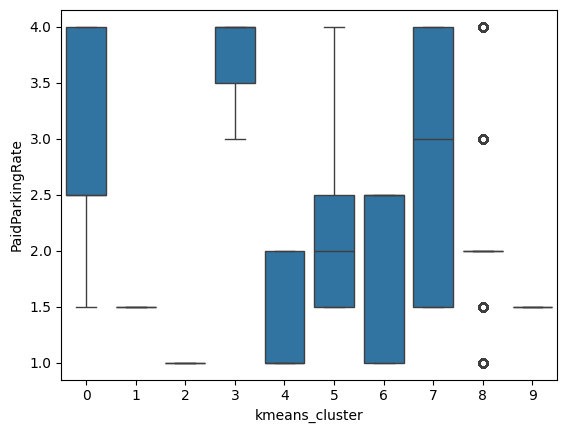

In [15]:
#Comparative Analysis of Clusters:
sns.boxplot(x='kmeans_cluster', y='PaidParkingRate', data=data)
plt.show()

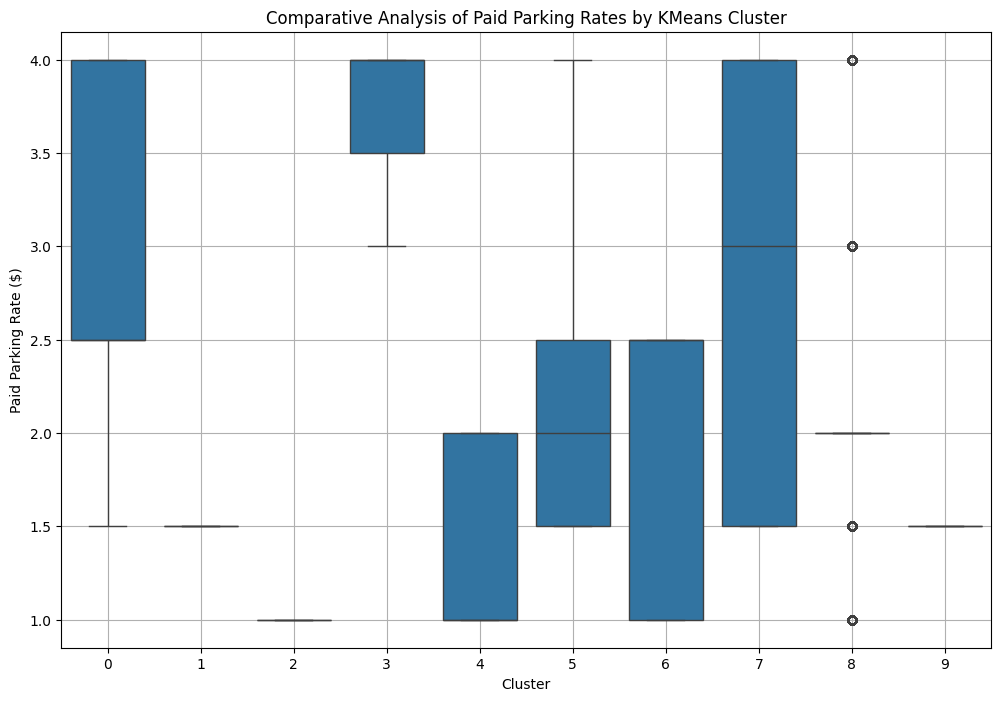

ANOVA test results: F-Statistic = nan, P-value = nan


In [16]:
# Perform comparative analysis of clusters using boxplots
from scipy.stats import f_oneway

plt.figure(figsize=(12, 8))
sns.boxplot(data=data, x='kmeans_cluster', y='PaidParkingRate')
plt.title('Comparative Analysis of Paid Parking Rates by KMeans Cluster')
plt.xlabel('Cluster')
plt.ylabel('Paid Parking Rate ($)')
plt.grid(True)
plt.show()

# Perform ANOVA to test for significant differences in PaidParkingRate across clusters
anova_data = [data[data['kmeans_cluster'] == cluster]['PaidParkingRate'] for cluster in data['kmeans_cluster'].unique()]
f_statistic, p_value = f_oneway(*anova_data)
print(f"ANOVA test results: F-Statistic = {f_statistic}, P-value = {p_value}")

In [17]:
# ## Please use ARC to run this cell, Running on low end machine will take a lot of time or the Kernal might crash

# import pandas as pd
# import geopandas as gpd
# import numpy as np
# import matplotlib.pyplot as plt
# from shapely.geometry import Point
# from pysal.lib import weights
# from pysal.explore import esda
# from scipy.spatial.distance import pdist, squareform
# # Assuming average_data is your DataFrame with 'Longitude' and 'Latitude' columns
# filtered_data = data[(data['Day'] == 28) & (data['Month'] == 3)]
# # Group by 'SourceElementKey' and calculate the average 'PaidParkingRate' and 'DistanceFromDowntown'
# average_data = filtered_data.groupby('SourceElementKey')[['PaidParkingRate', 'DistanceFromDowntown', 'Latitude', 'Longitude']].mean().reset_index()

# print(average_data.head())
# # First, check the distribution
# from sklearn.utils import resample
# print(average_data['DistanceFromDowntown'].value_counts())

# # Define a threshold count to identify overrepresented distances
# threshold = 100  # for example, any distance count greater than 100 will be undersampled

# # Get the list of distances to undersample
# distances_to_undersample = average_data['PaidParkingRate'].value_counts()[average_data['PaidParkingRate'].value_counts() > threshold].index

# # Perform undersampling
# undersampled_data = pd.DataFrame()
# for dist in distances_to_undersample:
#     # Get the subset of data for the specific distance
#     subset = average_data[average_data['PaidParkingRate'] == dist]
    
#     # Resample the subset
#     subset_undersampled = resample(subset, 
#                                    replace=False,    # sample without replacement
#                                    n_samples=threshold,  # to match minority class
#                                    random_state=123)  # reproducible results
    
#     # Append the undersampled subset to the new dataframe
#     undersampled_data = pd.concat([undersampled_data, subset_undersampled])

# # Append the rest of the data (not undersampled)
# data_undersampled = pd.concat([undersampled_data, average_data[~average_data['PaidParkingRate'].isin(distances_to_undersample)]])

# # Now you have a balanced dataset based on the threshold
# print(data_undersampled['PaidParkingRate'].value_counts())
# # Create a GeoDataFrame with the appropriate coordinate reference system
# gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude))
# gdf.set_crs(epsg=4326, inplace=True)

# # Calculate the spatial weight matrix using latitude and longitude
# w = weights.DistanceBand.from_dataframe(gdf, threshold=2000, binary=False, silence_warnings=True)

# # Variogram Analysis
# y = gdf['PaidParkingRate'].values
# X = gdf[['DistanceFromDowntown']].values

# # Compute spatial lag
# lag = weights.lag_spatial(w, y)

# # Plot the variogram
# fig, ax = plt.subplots(1, 1, figsize=(15, 7))

# # Plot 1: Variogram
# ax.scatter(X, y, color='black', label='Data Point')
# ax.scatter(X, lag, color='red', label='Spatial Lag')
# ax.set_title('Variogram')
# ax.set_xlabel('Distance From Downtown')
# ax.set_ylabel('PaidParkingRate')
# ax.legend()

# # Variogram Cloud
# # Compute pairwise distances between all points
# coords = gdf[['Longitude', 'Latitude']]
# pairwise_distances = squareform(pdist(coords))

# # Compute the square root of absolute difference in PaidParkingRate
# pairwise_differences = np.sqrt(np.abs(np.subtract.outer(y, y)))

# # # Plot 2: Variogram Cloud
# # ax[1].scatter(pairwise_distances.ravel(), pairwise_differences.ravel(), alpha=0.5)
# # ax[1].set_title('Variogram Cloud')
# # ax[1].set_xlabel('Pairwise Distance')
# # ax[1].set_ylabel('Square Root of Absolute Difference in PaidParkingRate')

# plt.tight_layout()
# plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


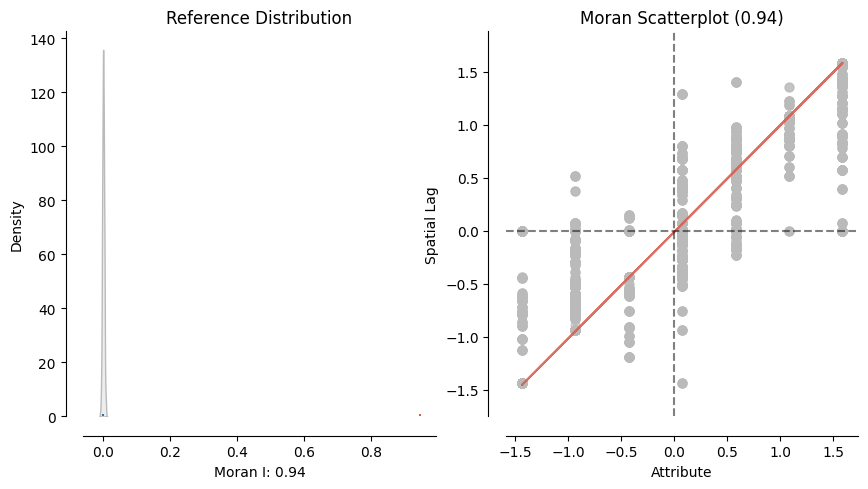

In [18]:
from libpysal.weights import DistanceBand
from esda.moran import Moran
from splot.esda import plot_moran
import geopandas as gpd
import matplotlib.pyplot as plt


filtered_data = data[(data['Day'] == 28) & (data['Month'] == 3)]
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(filtered_data, geometry=gpd.points_from_xy(filtered_data['Longitude'], filtered_data['Latitude']))

# Extract the target variable
y = gdf['PaidParkingRate'].values

# Create a spatial weights matrix with a specified threshold distance
w = DistanceBand.from_dataframe(gdf, threshold=0.001, binary=True, silence_warnings=True)

# Row-standardize the weights
w.transform = 'R'

# Calculate Moran's I
moran = Moran(y, w)

# Plot Moran's I result using the plot_moran function
# Note: Do not create a separate figure and axes before this function call
plot_moran(moran, zstandard=True, figsize=(10, 5))
plt.show()


In [20]:
import geopandas as gpd
import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans

# Assuming 'gdf' is the GeoDataFrame created earlier with 'Latitude' and 'Longitude'
##Nikhil's Code
import geopandas as gpd
import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt
# Convert 'OccupancyDateTime' to datetime
#reg_df['OccupancyDateTime'] = pd.to_datetime(reg_df['OccupancyDateTime'])

# Filter data for a specific date
#specific_date = '2015-01-15'
#data_filtered = reg_df[reg_df['OccupancyDateTime'].dt.date == pd.to_datetime(specific_date).date()]
pd.set_option('display.max_columns', 500)
data_filtered = data = pd.read_csv('geo_df.csv')
#data_filtered = pd.read_csv('ChaisPreprocessing.csv')
#data_filtered = data_filtered.head(30)

filtered_data = data_filtered[(data_filtered['Day'] == 28) & (data_filtered['Month'] == 3)]
print(filtered_data.head())
df = filtered_data.copy()
G = nx.complete_graph(len(df))

# Mapping the nodes to the SourceElementKey
mapping = {i: key for i, key in enumerate(df['SourceElementKey'])}
G = nx.relabel_nodes(G, mapping)

# Now let's try recalculating the centrality measures with the assumption that all nodes are interconnected.
eigen_centrality = nx.eigenvector_centrality(G, max_iter=1000)
closeness_centrality = nx.closeness_centrality(G)
harmonic_centrality = nx.harmonic_centrality(G)

# Information centrality is not a built-in function in NetworkX, and it typically refers to the flow of information.
# In a fully connected graph, the information centrality would be uniform across all nodes, 
# since they all have the same degree of connection.
# Therefore, we will calculate the degree centrality instead, which is a simpler measure and is well-defined for complete graphs.
degree_centrality = nx.degree_centrality(G)

# Combine the centrality measures into the original dataframe
df['EigenCentrality'] = df['SourceElementKey'].map(eigen_centrality)
df['ClosenessCentrality'] = df['SourceElementKey'].map(closeness_centrality)
df['HarmonicCentrality'] = df['SourceElementKey'].map(harmonic_centrality)
df['DegreeCentrality'] = df['SourceElementKey'].map(degree_centrality)

# Display the dataframe with the new centrality measures
df[['SourceElementKey', 'EigenCentrality', 'ClosenessCentrality', 'HarmonicCentrality', 'DegreeCentrality']]
# Group by 'SourceElementKey' and calculate the mean 'PaidParkingRate'
parking_avg_rates = df.groupby('SourceElementKey').agg({
    'PaidParkingRate': 'mean',
    'Latitude': 'first',
    'Longitude': 'first'
}).reset_index()

# Create a GeoDataFrame with the average rates and their corresponding coordinates
gdf = gpd.GeoDataFrame(parking_avg_rates, geometry=gpd.points_from_xy(parking_avg_rates.Longitude, parking_avg_rates.Latitude))

# Set the coordinate reference system (CRS) to WGS84 (epsg:4326) and then to Web Mercator (epsg:3857) for contextily
gdf = gdf.set_crs('epsg:4326')
gdf = gdf.to_crs(epsg=3857)

# Calculate the bounds of the GeoDataFrame
bounds = gdf.total_bounds

# Plotting the background map without any points
fig, ax = plt.subplots(figsize=(12, 10))

# Set the bounds for the axis
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

# Add the background map
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set the aspect of the plot to be equal
ax.set_aspect('equal')

# Remove the axis for a cleaner look
ax.axis('off')

# Add title
plt.title(f'Map of Seattle')

# Display the plot

plt.show()




/var/folders/g8/gc9zn7d515q2qc1hg5fc4kf00000gn/T/ipykernel_59893/3199113649.py:23: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  data_filtered = data = pd.read_csv('geo_df.csv')


        Unnamed: 0  PaidOccupancy SideOfStreet  SourceElementKey  \
499852         260              2           SE             79570   
499853         261              1           SE             77610   
499854         262              1           SE             58078   
499855         263              1           NE              8242   
499856         264              1           NE             53422   

        ParkingTimeLimitCategory  ParkingSpaceCount  PaidParkingRate  \
499852                       120                  7              4.0   
499853                       120                  4              4.0   
499854                       120                  3              4.0   
499855                       120                  8              4.0   
499856                       120                  7              4.0   

       ParkingCategory   Latitude   Longitude  is_us_holiday  temp  feelslike  \
499852    Paid Parking  47.606274 -122.332306          False  51.4       51.4

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import numpy as np
import contextily as ctx
from scipy.spatial import cKDTree

# Load your data into a DataFrame
#data_filtered = pd.read_csv('ChaisPreprocessing.csv')
data_read = pd.read_csv('geo_df.csv')
# Assume that we are working with the first 100 entries for demonstration

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(data_read, geometry=gpd.points_from_xy(data_read.Longitude, data_read.Latitude))
gdf.crs = "EPSG:4326"
gdf = gdf.to_crs(epsg=3857)

# Calculate KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
gdf['kmeans_cluster'] = kmeans.fit_predict(gdf[['Longitude', 'Latitude']])

# Create KDTree for efficient nearest neighbor search
tree = cKDTree(gdf[['Longitude', 'Latitude']].values)

# Function to calculate the mean centrality for the nearest three parking facilities in each district
def calculate_mean_centrality(kd_tree, gdf, centrality_column, k=4):
    # k=4 because the first nearest neighbor is the point itself
    dists, idxs = kd_tree.query(gdf[['Longitude', 'Latitude']].values, k=k)
    # Skip the first column of idxs which is the point itself
    idxs = idxs[:, 1:]
    # Calculate the mean centrality score of the three nearest neighbors
    mean_centralities = []
    for neighbors_idxs in idxs:
        mean_centralities.append(gdf.iloc[neighbors_idxs][centrality_column].mean())
    return mean_centralities

# Rest of the code remains unchanged...


# Use 'PaidParkingRate' as a proxy for centrality measures for this example
gdf['DistanceBasedCentrality'] = gdf['PaidParkingRate']
gdf['TimeBasedCentrality'] = 1 / gdf['PaidParkingRate']  # Assuming higher rates mean lower time

# Calculate mean centralities for distance-based and time-based centrality
gdf['MeanDistanceBasedCentrality'] = calculate_mean_centrality(tree, gdf, 'DistanceBasedCentrality')
gdf['MeanTimeBasedCentrality'] = calculate_mean_centrality(tree, gdf, 'TimeBasedCentrality')

# Plot the heatmaps
fig, axs = plt.subplots(2, 1, figsize=(15, 10), constrained_layout=True)

# Distance-based Centrality
gdf.plot(column='MeanDistanceBasedCentrality', ax=axs[0], cmap='coolwarm', legend=True, alpha=0.6)
ctx.add_basemap(axs[0], source=ctx.providers.OpenStreetMap.Mapnik)
axs[0].set_title('Mean Distance-Based Centrality')
axs[0].axis('off')

# Time-based Centrality
gdf.plot(column='MeanTimeBasedCentrality', ax=axs[1], cmap='coolwarm', legend=True, alpha=0.6)
ctx.add_basemap(axs[1], source=ctx.providers.OpenStreetMap.Mapnik)
axs[1].set_title('Mean Time-Based Centrality')
axs[1].axis('off')

plt.show()